In [1]:
import numpy as np
import pandas as pd

In [2]:
from pathlib import Path
from keras.preprocessing import image

path_train = './Desktop/Artyom_DS/Neural_networks_int/cityscapes_data/train/'
path_validation = './Desktop/Artyom_DS/Neural_networks_int/cityscapes_data/val/'

# path_train = pd.read_csv('./Desktop/Artyom_DS/Neural_networks_int/cityscapes_data/train.csv')
# path_validation = pd.read_csv('./Desktop/Artyom_DS/Neural_networks_int/cityscapes_data/val.csv')


train_images_paths = list(Path(path_train).iterdir())
validation_images_paths = list(Path(path_validation).iterdir())

In [3]:
single_image = image.load_img(train_images_paths[0])
image_size = (int(single_image.size[0]/2), single_image.size[1])
image_size

(256, 256)

In [4]:
def load_images_with_masks(paths):
    images = []
    masks = []

    for path in train_images_paths:
        temp_img = image.load_img(path) 
        img = temp_img.crop((0, 0, image_size[0], image_size[1])) 
        mask = temp_img.crop((image_size[0], 0, image_size[0] * 2, image_size[1]))
        images.append(img)
        masks.append(mask)

    return images, masks

images, masks = load_images_with_masks(train_images_paths)

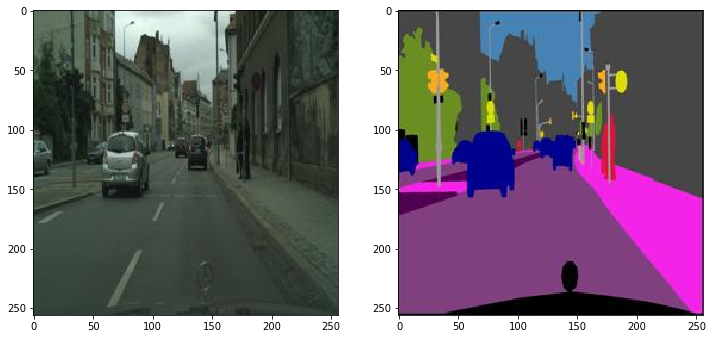

In [5]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(images[80].convert('RGBA'))
ax[1].imshow(masks[80].convert('RGBA'))

In [6]:
def extract_classes_from_masks(masks, gradations_number=3):
    classes = set()
    max_color_value = 255
    color_group_divider = int(max_color_value / gradations_number) 

    for mask in masks:
        for pixel in masks[0].convert('RGBA').getdata():
            r = int(pixel[0] / color_group_divider) * color_group_divider
            g = int(pixel[1] / color_group_divider) * color_group_divider
            b = int(pixel[2] / color_group_divider) * color_group_divider
            classes.add((r, g, b,))

    return [[item[0], item[1], item[2]] for item in list(classes)]

In [ ]:
classes = extract_classes_from_masks(masks, 3)

In [ ]:
def get_X_from_images(images):
    X = []

    for img in images:
        x = image.img_to_array(img)
        X.append(x)

    X = np.array(X)

    return X

In [ ]:
X = get_X_from_images(images)

In [ ]:
def Color2index(y, classes):
    y_ind = np.zeros((y.shape[0], y.shape[1]))
    y_cat = np.zeros((y.shape[0], y.shape[1], len(classes)))
    i = 1
    for color in classes:
        ind_i = np.where(
            (y[..., 0] >= color[0]) & (y[..., 0] <= color[0] + 85) 
            & (y[..., 1] >= color[1]) & (y[..., 1] <= color[1] + 85)
            & (y[..., 2] >= color[2]) & (y[..., 2] <= color[2] + 85)
        )
        y_ind[ind_i[0], ind_i[1]] = i
        y_cat[ind_i[0], ind_i[1], i-1] = 1 
        i += 1
    
    return y_cat, y_ind

In [ ]:
from keras.preprocessing import image
cat_yi, ind_yi = Color2index(image.img_to_array(masks[0]), classes)

plt.imshow(ind_yi)
plt.show()

In [ ]:
ind_yi

In [ ]:
plt.imshow(cat_yi[..., 4])
plt.show()

In [ ]:
cat_yi.shape

In [ ]:
def get_target_from_masks(masks):
  y = []

  for mask in masks[0:500]:
    y_cat, y_in = Color2index(image.img_to_array(mask), classes)
    y.append(y_cat)

  y = np.array(y)

  return y

In [ ]:
y = get_target_from_masks(masks)

In [ ]:
classes

In [ ]:
y.shape

In [ ]:
n = 4
plt.imshow(masks[n].convert('RGBA'))
plt.show()
img = y[n][..., 4]

plt.imshow(img)
plt.show()

In [ ]:
N = 300
y_train = y[:N, ...]
X_train = X[:N, ...]

y_test = y[N:, ...]
X_test = X[N:, ...]

In [ ]:
y_test.shape

In [ ]:
print(X_train.shape)
print(y_train.shape)

In [ ]:
from keras.models import Model
from keras.layers import (Activation, Input, MaxPooling2D, BatchNormalization, 
                          Conv2D, Conv2DTranspose, concatenate)
from tensorflow.keras.utils import plot_model

def Unet(num_classes=28, input_shape=(256, 256, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)


    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)


    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)


    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

 
    # UP 1
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    return model

In [ ]:
import keras.backend as K

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred)) / (K.sum(y_true) + K.sum(y_pred))

In [ ]:
import keras
from IPython.display import clear_output


def show_predictions(model):
    pred_mask = model.predict(sample_image[None])[..., 0]
    print(pred_mask.shape)

    fig, ax = plt.subplots(1, 3, figsize=(15, 8))

    ax[0].imshow(sample_image / 255.0)
    ax[1].imshow(sample_mask[..., 0])
    ax[2].imshow(np.squeeze(pred_mask, axis=0))
    plt.show()


class DisplayCallback(keras.callbacks.Callback):
    def __init__(self, patience=1):
        super().__init__()
        self.patience = patience
    
    def on_train_begin(self, logs=None):
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        self.wait += 1
        if self.wait >= self.patience:
            clear_output(wait=True)
            show_predictions(self.model)
            print(f'\nSample Prediction after epoch {epoch+1}')
            self.wait = 0

In [ ]:
import tensorflow
from tensorflow.keras.optimizers import Adam

model = Unet()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[dice_coef])
model.summary()

In [ ]:
X_train[0], y_train[0]

In [ ]:
print(X_test.shape)
print(y_test.shape)

In [ ]:
MODEL_WEIGHTS_PATH = 'model_weights.h5'

In [ ]:
model.load_weights(MODEL_WEIGHTS_PATH)

In [ ]:
val_images, val_masks = load_images_with_masks(validation_images_paths)

In [ ]:
X_val = get_X_from_images(val_images)

In [ ]:
y_val = get_target_from_masks(val_masks)

In [ ]:
pred = model.predict(X_val[0:50])
print(pred.shape)

In [ ]:
n = 11
class_ = 4
plt.imshow(val_images[n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(val_masks[n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()

img = y_val[n][..., class_]
plt.imshow(img)
plt.title('целевая разметка класс: ' + str(class_))
plt.show()
img = pred[n - 1][..., class_]
plt.imshow(img)
plt.title('предиктивная разметка класс: ' + str(class_))
plt.show()